In [16]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [17]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [19]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [21]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [22]:
# Save references to each table
Measurement_tbl = Base.classes.measurement
Station_tbl = Base.classes.station

In [23]:
# To check the columns in the measurement table
Measurement_tbl.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [24]:
# To check the columns in the station table
Station_tbl.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [26]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement_tbl.date).order_by(Measurement_tbl.date.desc()).first()

recent_date[0]

'2017-08-23'

In [31]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.
last_12_months_ago_date = dt.datetime.strptime(recent_date[0],'%Y-%m-%d') - relativedelta(months=12)

last_12_months_ago_date_format = last_12_months_ago_date.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
year_long_precipitation = session.query(Measurement_tbl.date, Measurement_tbl.prcp).\
                                    filter(Measurement_tbl.date.between(last_12_months_ago_date_format,recent_date[0])).\
                                    order_by(Measurement_tbl.date).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Handled the NAN values
year_long_precipitation_df = pd.DataFrame(year_long_precipitation, columns=['Date','Precipitation']).dropna()

# Sort the dataframe by date 
# Display the dataframe as it was already sorted using the order_by in the data retreival
# Setting the index on the Date column
year_long_precipitation_df.set_index('Date', inplace=True)
year_long_precipitation_df.head()


,Precipitation
Date,
2016-08-23,0.0
2016-08-23,3.8
2016-08-23,1.3
2016-08-23,0.5
2016-08-23,45.5


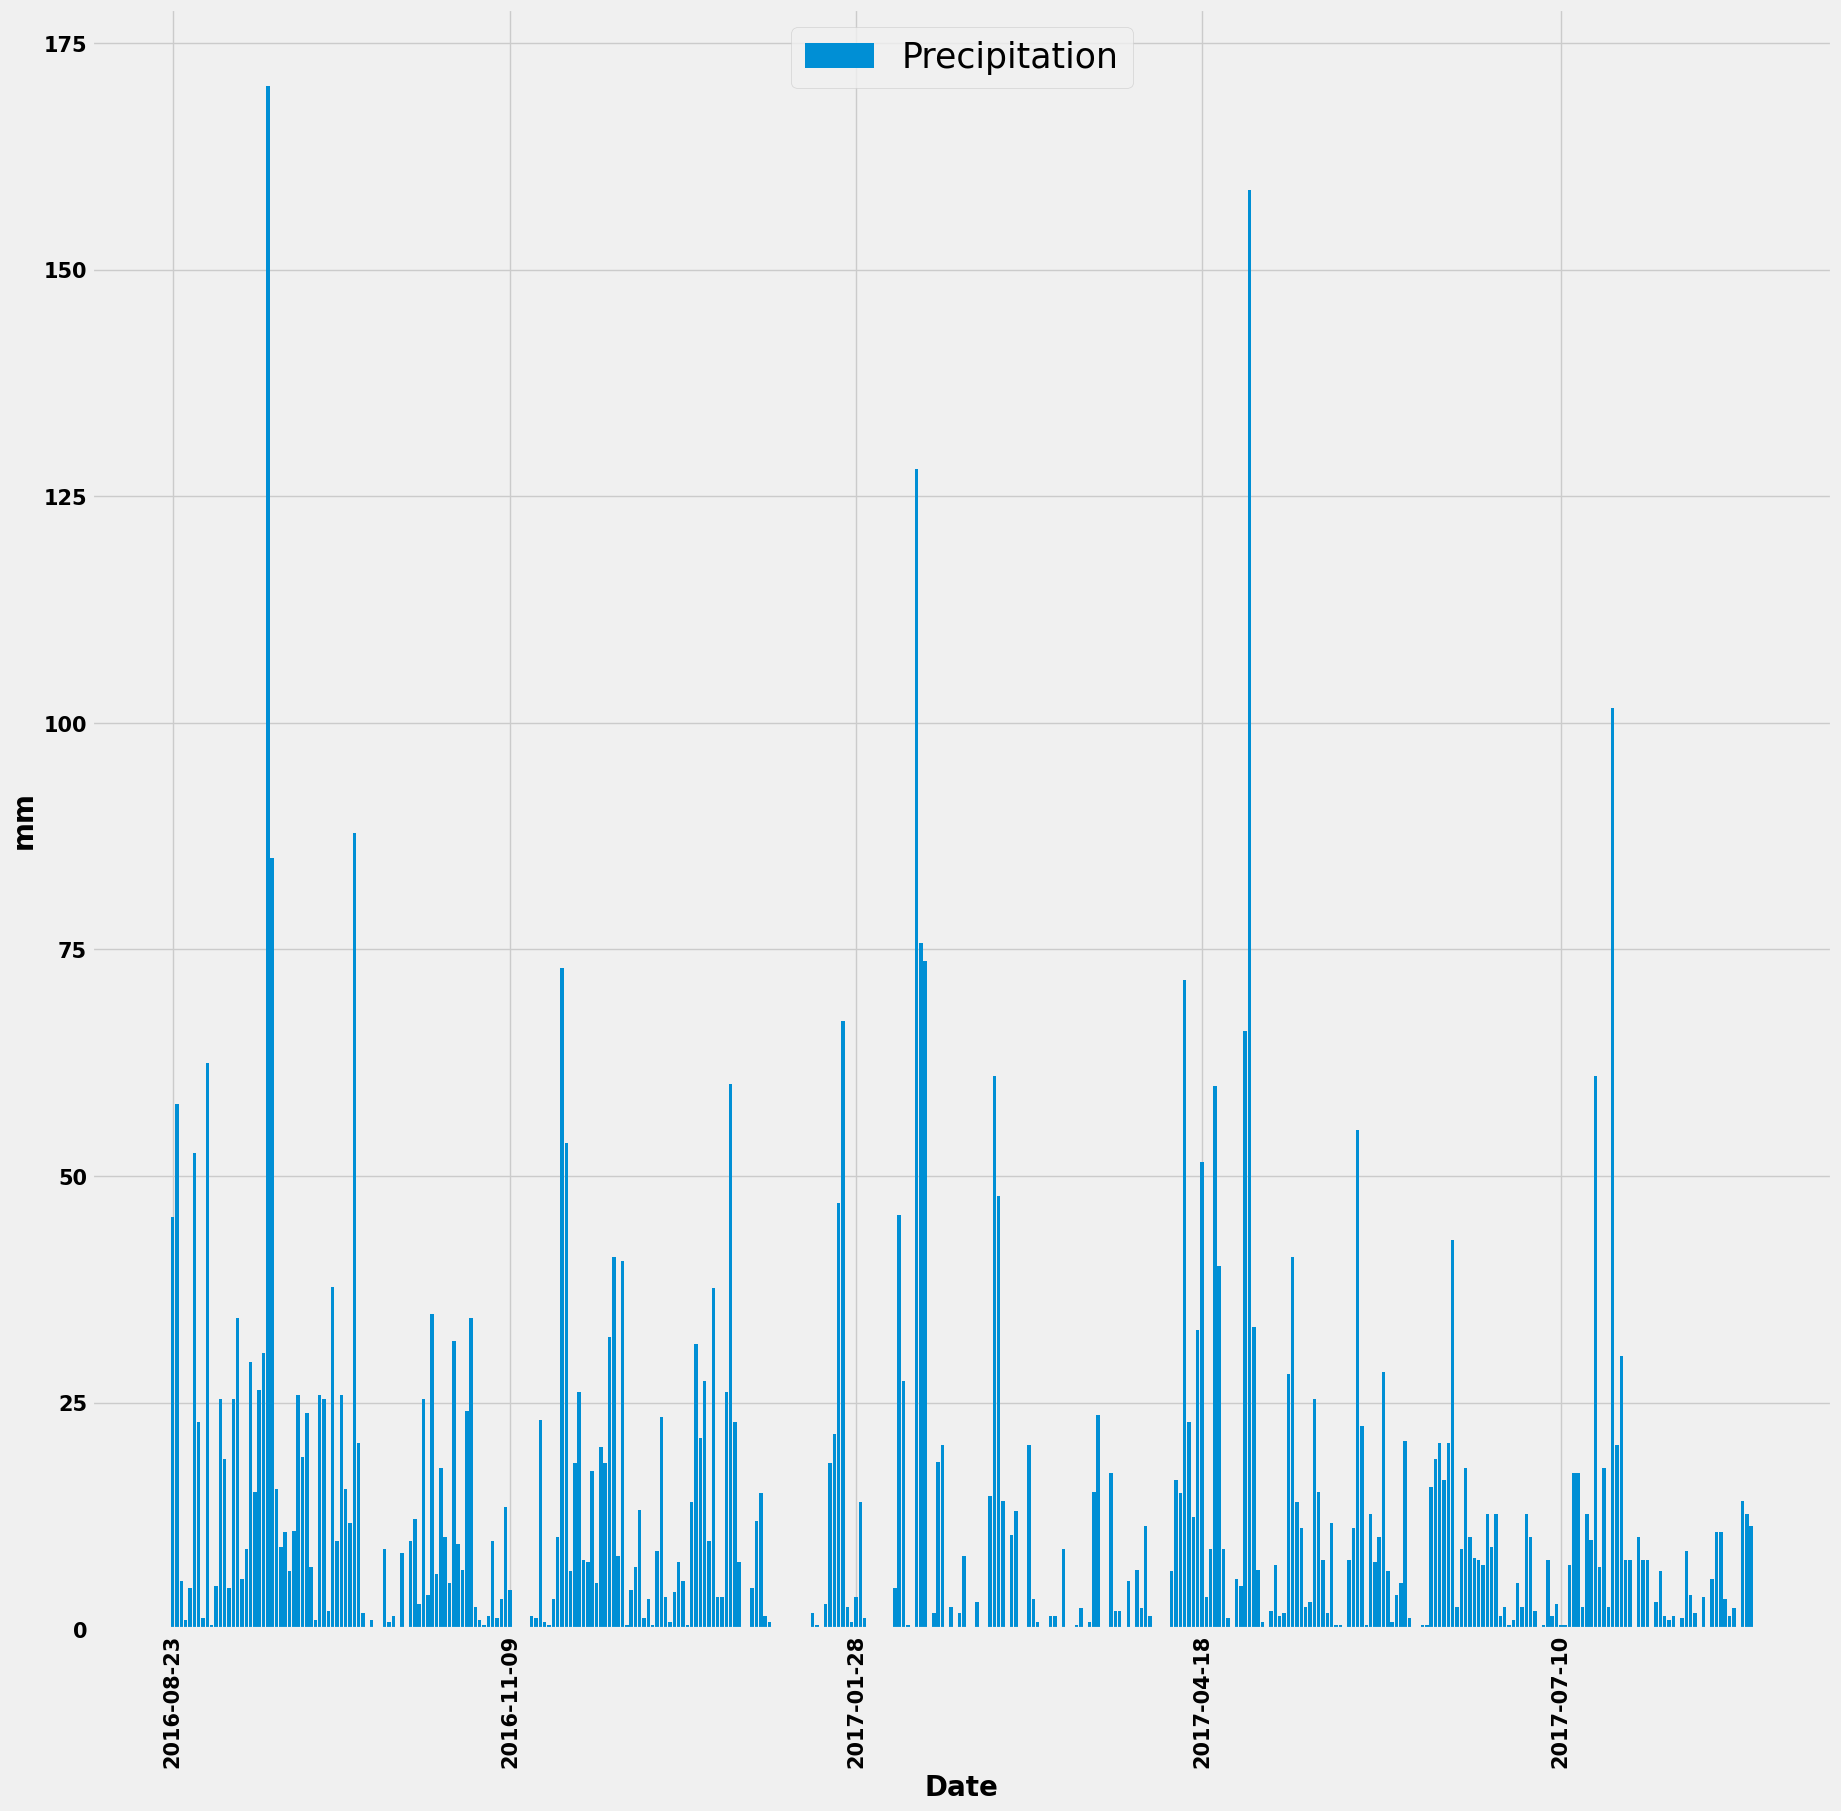

In [38]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(20,20))
plt.bar(year_long_precipitation_df.index, year_long_precipitation_df['Precipitation'])
plt.legend(['Precipitation'], loc="upper center", fontsize=25)

# X-axis label settings as dataframe contains more labels so explicitly setting labels 
xloc = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18','2017-07-10']
yloc = [0, 25, 50, 75, 100, 125, 150, 175]
plt.xticks(xloc, rotation='vertical', fontsize = 15, fontweight='bold')
plt.yticks(yloc,fontsize=15, fontweight='bold')

# setting up labels
plt.xlabel('Date', fontsize=20, fontweight='bold')
plt.ylabel('mm', fontsize=20, fontweight='bold')
plt.show()

In [32]:
# Use Pandas to calculate the summary statistics for the precipitation data
year_long_precipitation_df.describe()

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [40]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station_tbl.id).count()

9

In [45]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = [Measurement_tbl.station, func.count(Measurement_tbl.id)]

active_stations_list = session.query(*most_active_stations).group_by(Measurement_tbl.station).\
                            order_by(func.count(Measurement_tbl.id).desc()).all()


active_stations_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [57]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations_list[0][0]

temperature = session.query(func.min(Measurement_tbl.tobs), func.max(Measurement_tbl.tobs), func.avg(Measurement_tbl.tobs)).\
                                        filter(Measurement_tbl.station == most_active_station_id).all()


print(f'The lowest temperature for most active station id {most_active_station_id} = {temperature[0][0]}')
print(f'The highest temperature for most active station id {most_active_station_id} = {temperature[0][1]}')
print(f'The average temperature for most active station id {most_active_station_id} = {temperature[0][2]}')


The lowest temperature for most active station id USC00519281 = 12.2
The highest temperature for most active station id USC00519281 = 29.4
The average temperature for most active station id USC00519281 = 22.03582251082252


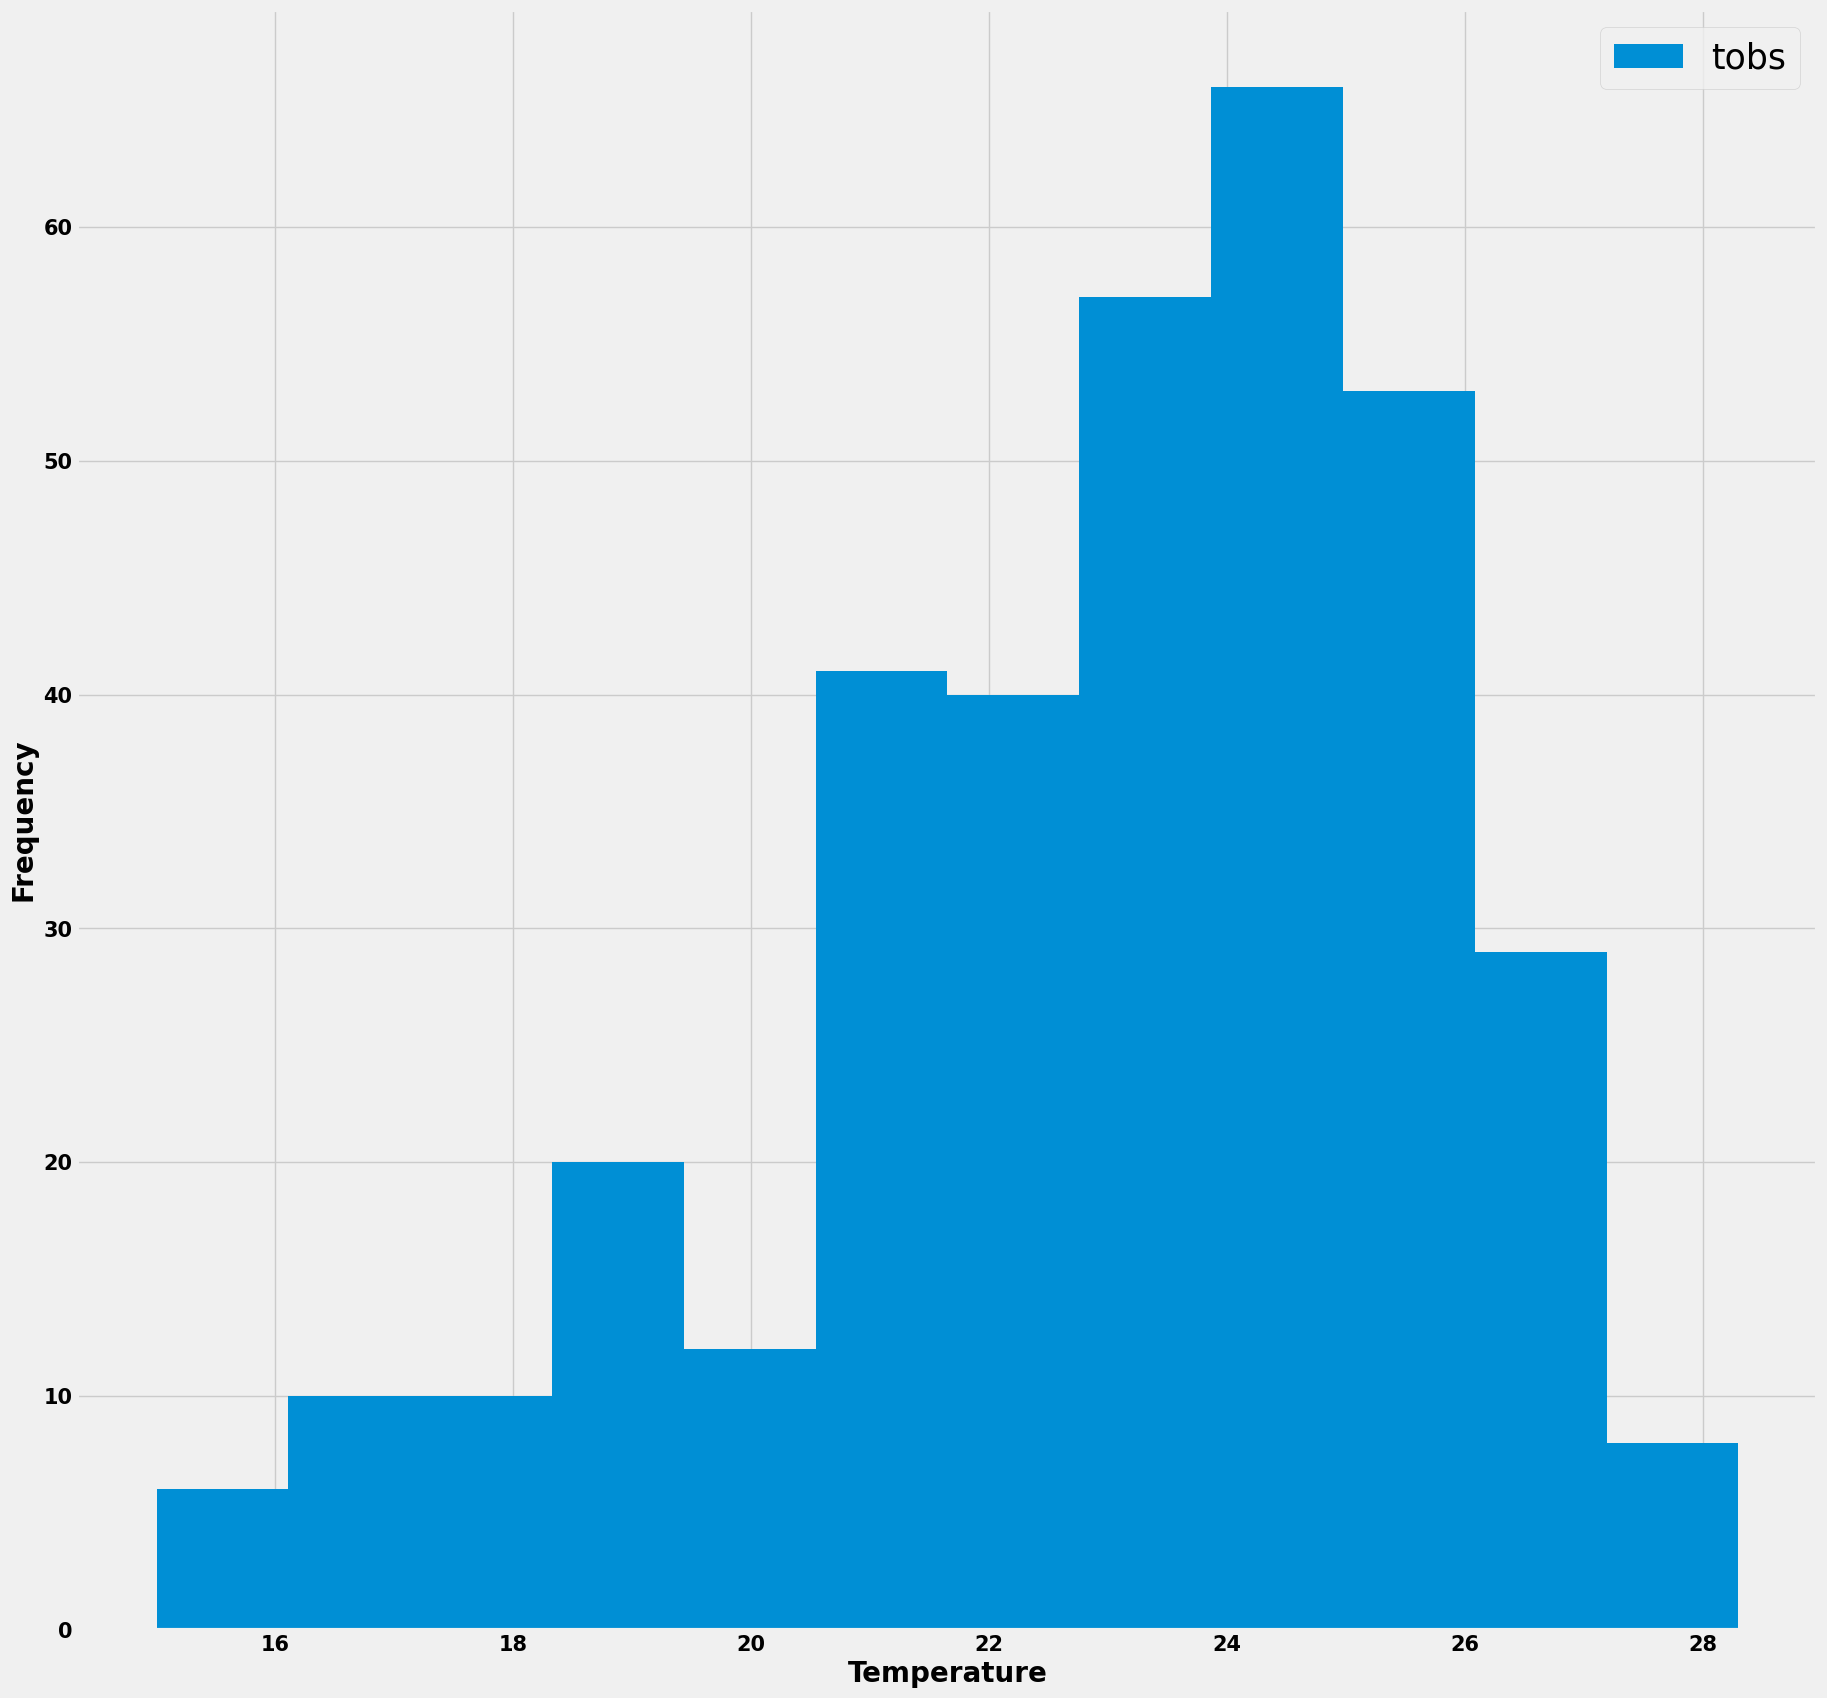

<Figure size 640x480 with 0 Axes>

In [70]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_12_months_temperature = session.query(Measurement_tbl.tobs).\
                                    filter(Measurement_tbl.date.between(last_12_months_ago_date_format,recent_date[0]),\
                                           Measurement_tbl.station == most_active_station_id).all()



# plot the results as a histogram
plt.figure(figsize=(20,20))
plt.hist(np.ravel(last_12_months_temperature),bins=12)
plt.legend(['tobs'], loc="upper right", fontsize=25)

# X-axis label settings as dataframe contains more labels so explicitly setting labels 
plt.xticks(fontsize = 15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')

# setting up labels
plt.xlabel('Temperature', fontsize=20, fontweight='bold')
plt.ylabel('Frequency', fontsize=20, fontweight='bold')
plt.show()
plt.tight_layout()



# Close Session

In [69]:
# Close Session
session.close()